In [1]:
import warnings
warnings.filterwarnings("ignore")
import cv2
import pandas as pd
import os
from os import listdir
from os.path import join, isfile, splitext, basename, isdir
import numpy as np
import dlib
import imutils
import matplotlib.pyplot as plt
import time
import math
from shutil import copyfile
import pickle
import gc

import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import BatchNormalization, Input, Dense, Conv2D, MaxPooling2D, Dropout, Flatten, Activation, AveragePooling2D, ZeroPadding2D, Concatenate, Reshape
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping #prevent losing model training since my computer shuts down alot when overheat
from tensorflow.keras.utils import to_categorical, Sequence

from tensorflow.keras.applications import ResNet50, VGG16, InceptionV3, VGG19, DenseNet121

import matplotlib.pyplot as plt

from facial_landmark import FacialLandmark #this py file is created to help on this project
import models_collection

In [2]:
resnet_weights_path = './pretrained_model/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5'

PICTURES_DIR = "./data/image_pool"
FILTERED_DIR = "./data/filtered_image_pool"

IMAGES_DATA_PKL_PATH = "./data/images_dataset.pkl"
IMAGES_DATA_PKL_COLUMNS = ["image_name", "image_width", "image_height", "age", "gender", "face_landmark", "race"]
VIEWED_PKL_PATH = "./data/viewed_image.pkl"
VIEWED_PKL_COLUMNS = ["image_name"]

BACKUP_IMAGES_DATA_PKL_PATH = "./data/auto_backup/images_dataset_auto_bck.pkl"
BACKUP_VIEWED_PKL_PATH = "./data/auto_backup/viewed_image_auto_bck.pkl"

In [3]:
class DataGenerator(Sequence):
    def __init__(self, list_IDs, labels, img_path, to_fit=True, batch_size=32, dim=(256,256), n_channels=3, n_classes=5, shuffle=True):
        self.list_IDs = list_IDs
        self.labels = labels
        self.img_path = img_path
        self.to_fit = to_fit
        self.batch_size = batch_size
        self.dim = dim
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.on_epoch_end()
        
    def __len__(self):
        return int(np.floor(len(self.list_IDs) / self.batch_size))
    def on_epoch_end(self):
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)
            
    def __getitem__(self, index):
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        list_IDs_temp = [self.list_IDs[k] for k in indexes]
        
        data = self._generate_data(list_IDs_temp)

        if self.to_fit:
            X, y = data
            return X, y
        else:
            return data
    
    def _generate_data(self, list_IDs):
        X = np.empty((self.batch_size, *self.dim, self.n_channels))
        if self.to_fit:
            y = np.empty((self.batch_size), dtype=int)
#         print("loading", len(list_IDs), "images")
        for i, image_name in enumerate(list_IDs):
            pure_name = splitext(image_name)[0]
            split_pure_name = pure_name.split('_')
            if split_pure_name[-1] == "mirror":
                actual_image_name = "_".join(split_pure_name[:-1])+splitext(image_name)[1]
                image_path = join(self.img_path, actual_image_name)
                image_BGR_mir = cv2.imread(image_path)
                image_BGR = cv2.flip(image_BGR_mir, 1)
            else:
                image_path = join(self.img_path, image_name)
                image_BGR = cv2.imread(image_path)
            
            image_RGB = cv2.cvtColor(image_BGR, cv2.COLOR_BGR2RGB)
            image_resized = cv2.resize(image_RGB, self.dim, interpolation = cv2.INTER_LINEAR)
            image_adjusted = image_resized / 255.0
            X[i,] = image_adjusted
            if self.to_fit:
                y[i,] = self.labels[image_name]
#         print("Done:", len(list_IDs),"Image loaded")
        if not self.to_fit:
            return X
        else:
            return (X,to_categorical(y, num_classes=self.n_classes))

In [4]:
def add_mirror_tag(img_name):
    name_ext = splitext(img_name)
    return name_ext[0] + "_mirror" + name_ext[1]

def df_to_name_label(input_df):
    images_name = []
    images_label = {}
    for i in range(input_df.shape[0]):
        image_name = input_df.iloc[i,:]['image_name']
        race = input_df.iloc[i,:]['race']

        images_name.append(image_name)
        images_label[image_name] = (int(race))
    return (images_name, images_label)
    
RAND_STATE = 3035361635
FRAC = 1 #Tune this parameter to use just a fraction of the data. set it to 1 to use the all data in the pool
TRAIN_TEST_RATIO = 0.8
TRAIN_VAL_RATIO = 0.8
image_pool_df = pd.read_pickle(IMAGES_DATA_PKL_PATH)
#Shuffle input images
input_images = image_pool_df.sample(frac = FRAC, random_state = RAND_STATE)

n_train = int(round(input_images.shape[0] * TRAIN_TEST_RATIO))
train_val_images_df = input_images[:n_train]
test_images_df = input_images[n_train:]

#split train val
n_train_val = int(round(train_val_images_df.shape[0] * TRAIN_VAL_RATIO))
train_images_df = train_val_images_df[:n_train_val]
val_images_df = train_val_images_df[n_train_val:]

#balancing train images
unique_race_series = train_images_df.groupby('race')['image_name'].count()
unique_value = unique_race_series.values
unique_key =  unique_race_series.keys()
do_not_sample = unique_key[np.argmax(unique_value)]
sample_to = max(unique_value)

for key in unique_key:
    if not key == do_not_sample:
        key_df = train_images_df[train_images_df['race'] == key]
        samples = key_df.sample(n = sample_to - unique_race_series[key], replace = True, random_state = RAND_STATE)
        samples['image_name'] = samples['image_name'].apply(add_mirror_tag)
        train_images_df = pd.concat([train_images_df, samples], ignore_index = True)

# Shuffle train image
train_images_df = train_images_df.sample(frac = 1, random_state = RAND_STATE)
print("Processing training set")
x_train, y_train = df_to_name_label(train_images_df)
print("Processing validation set")
x_val, y_val = df_to_name_label(val_images_df)
print("Processing testing set")
x_test, y_test = df_to_name_label(test_images_df)


Processing training set
Processing validation set
Processing testing set


In [5]:
def create_transferlearning_resnet50():
    model = Sequential()
    model.add(ResNet50(include_top = False, pooling = 'avg', weights = resnet_weights_path))
    model.add(Dense(5, activation = 'softmax'))
    model.layers[0].trainable = False
    sgd = tf.keras.optimizers.SGD(lr = 0.01, decay = 1e-6, momentum = 0.9, nesterov = True)
    model.compile(optimizer = sgd, loss = 'categorical_crossentropy', metrics = ['accuracy'])
    return model

def create_transferlearning_VGG16():
    model = Sequential()
    model.add(VGG16(include_top = False, pooling = 'avg'))
    model.add(Dense(5, activation = 'softmax'))
    model.layers[0].trainable = False
    model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])
    return model

def create_transferlearning_VGG19():
    model = Sequential()
    model.add(VGG19(include_top = False, pooling = 'avg'))
    model.add(Dense(5, activation = 'softmax'))
    model.layers[0].trainable = False
    model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])
    return model


def create_transferlearning_InceptionV3():
    model = Sequential()
    model.add(InceptionV3(include_top = False, pooling = 'avg'))
    model.add(Dense(5, activation = 'softmax'))
    model.layers[0].trainable = False
    model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])
    return model

def create_transferlearning_DenseNet121():
    model = Sequential()
    model.add(DenseNet121(include_top = False, pooling = 'avg'))
    model.add(Dense(5, activation = 'softmax'))
    model.layers[0].trainable = False
    model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])
    return model

In [5]:
input_shape = (299, 299)
training_generator = DataGenerator(x_train, y_train, FILTERED_DIR, dim=input_shape)
validation_generator = DataGenerator(x_val, y_val, FILTERED_DIR, dim=input_shape)
test_generator = DataGenerator(x_test, y_test, FILTERED_DIR, dim=input_shape, batch_size=1, shuffle = False)

In [6]:
##### DONT FORGET CHANGE THESE PARAMETERS TO APPROPRIATE VALUE BEFORE RUNNING #####
# CALLBACK_MODEL_CHECKPOINT_BEST_VAL_LOSS = "./models/model_best_val_loss_alex_net.hdf5"
# CALLBACK_MODEL_CHECKPOINT_BEST_VAL_ACC = "./models/model_best_val_acc_alex_net.hdf5"

model_name = "transferlearning_DenseNet121"
create_my_model = create_transferlearning_DenseNet121 #This is a function btw
HISTORY_PICKLE_DIR = "./models_v2/history/" + model_name +"_history"
MODEL_SAVE_DIR = "./models_v2/" + model_name
CALLBACK_MODEL_CHECKPOINT_LAST_MODEL = join(MODEL_SAVE_DIR, "model_checkpoint_after_loop_" + model_name +".h5")
BEST_LOSS_PKL_PATH = join(HISTORY_PICKLE_DIR, "000_best_val_loss.pkl")
CONTINUE_TRAINING_PATH = join(MODEL_SAVE_DIR, "000_continue_training.pkl")

history_prefix = model_name + "_"
per_epoch = 10
max_loop = 500
save_model_every_n_epoch = 3 * per_epoch
check_save_best_loss_model_every_n_epoch = 1 * per_epoch
##### DONT FORGET CHANGE THESE PARAMETERS TO APPROPRIATE VALUE BEFORE RUNNING #####

if not os.path.exists(HISTORY_PICKLE_DIR):
    os.makedirs(HISTORY_PICKLE_DIR)
if not os.path.exists(MODEL_SAVE_DIR):
    os.makedirs(MODEL_SAVE_DIR)

#loading continue training if exist
if isfile(CONTINUE_TRAINING_PATH):
    with open(CONTINUE_TRAINING_PATH, 'rb') as handle:
        specific_start = pickle.load(handle)
else:
    specific_start = 0
print("Start at i =", specific_start)

#loading best val loss if exist
if isfile(BEST_LOSS_PKL_PATH):
    with open(BEST_LOSS_PKL_PATH, 'rb') as handle:
        best_loss = pickle.load(handle)
else:
    best_loss = float("inf")
print("Best loss =", best_loss)

callbacks = [ModelCheckpoint(CALLBACK_MODEL_CHECKPOINT_LAST_MODEL, monitor = 'val_loss', verbose = 1, save_best_only = False, save_weight_only = False, save_freq='epoch', period = per_epoch)]
# ModelCheckpoint(CALLBACK_MODEL_CHECKPOINT_BEST_VAL_LOSS, monitor = 'val_loss', verbose = 1, save_best_only = True, mode='auto', save_freq='epoch', period = 5)]
#             ModelCheckpoint(CALLBACK_MODEL_CHECKPOINT_BEST_VAL_ACC, monitor = 'val_acc', verbose = 1, save_best_only = True, mode='auto', save_freq='epoch', period = 2)]
#             EarlyStopping(monitor='val_loss', mode='auto', verbose=1, patience=3), EarlyStopping(monitor='val_acc', mode='auto', min_delta=1, patience = 3)

all_history = []

for i in range(specific_start, max_loop):
    if isfile(CALLBACK_MODEL_CHECKPOINT_LAST_MODEL):
        model = load_model(CALLBACK_MODEL_CHECKPOINT_LAST_MODEL)
        print("== model succesfully loaded ==")
    else:
        model = create_my_model()
        model.summary()
        print("== Created new model ==")
    pickle_name = history_prefix + str((i+1) * per_epoch) + ".pkl"
    pickle_path = join(HISTORY_PICKLE_DIR, pickle_name)
    model_history = model.fit(training_generator, validation_data = validation_generator, epochs = per_epoch, verbose = 1, callbacks = callbacks)
    
    #saving models
    curr_epoch = (i+1) * per_epoch
    #saving model manually per n epoch
    if curr_epoch != 0 and curr_epoch%save_model_every_n_epoch == 0:
        model_file_name = history_prefix + str(curr_epoch) + ".h5"
        model_saving_path = join(MODEL_SAVE_DIR, model_file_name)
        model.save(model_saving_path)
        print("==== Per_n_epoch: Model saved:", model_saving_path, "====")
    
    if curr_epoch != 0 and curr_epoch%check_save_best_loss_model_every_n_epoch == 0:
        last_loss = model_history.history['val_loss'][-1]
        if best_loss > last_loss:
            model_file_name = "000_" + history_prefix + "best_loss_" + str(curr_epoch) + ".h5"
            model_saving_path = join(MODEL_SAVE_DIR, model_file_name)
            model.save(model_saving_path)
            print("==== Loss improved ", best_loss,"to", last_loss,": Model saved:", model_saving_path, "====")
            best_loss = last_loss
            with open(BEST_LOSS_PKL_PATH, 'wb') as file_pi:
                pickle.dump(best_loss, file_pi)
            print("best val loss pkl updated")
    
    #save continue training
    cont_train = i+1
    with open(CONTINUE_TRAINING_PATH, 'wb') as file_pi:
        pickle.dump(cont_train, file_pi)
    print("training continue saved at", cont_train)
                
    all_history.append(model_history.history)
    
    #save history
    with open(pickle_path, 'wb') as file_pi:
        pickle.dump(model_history.history, file_pi)
    print("History saved:", pickle_name)
    #Trying to fix memory leak..
    del model
    del model_history
    gc.collect()
    K.clear_session()
    print("Session cleared and GC called")


Start at i = 0
Best loss = inf
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet121 (Model)          (None, 1024)              7037504   
_________________________________________________________________
dense (Dense)                (None, 5)                 5125      
Total params: 7,042,629
Trainable params: 5,125
Non-trainable params: 7,037,504
_________________________________________________________________
== Created new model ==
Epoch 1/10
875/875 [==============================] - 363s 415ms/step - loss: 1.2575 - acc: 0.4924 - val_loss: 2.2678 - val_acc: 0.1838
Epoch 2/10
875/875 [==============================] - 315s 360ms/step - loss: 1.0838 - acc: 0.5804 - val_loss: 2.3599 - val_acc: 0.2347
Epoch 3/10
875/875 [==============================] - 330s 

KeyboardInterrupt: 

transferlearning_VGG16


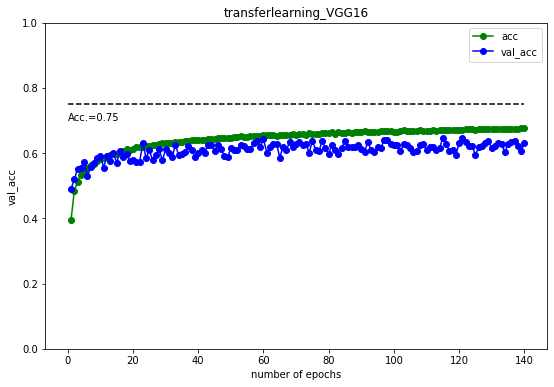

transferlearning_DenseNet121


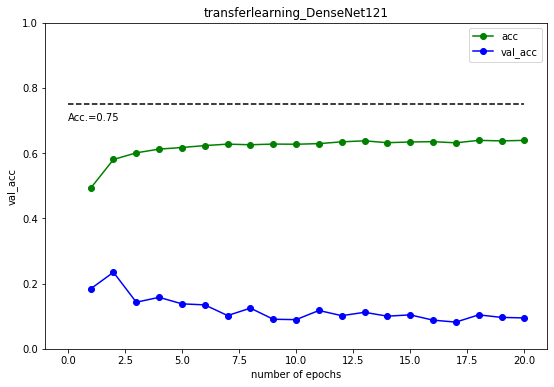

transferlearning_VGG19


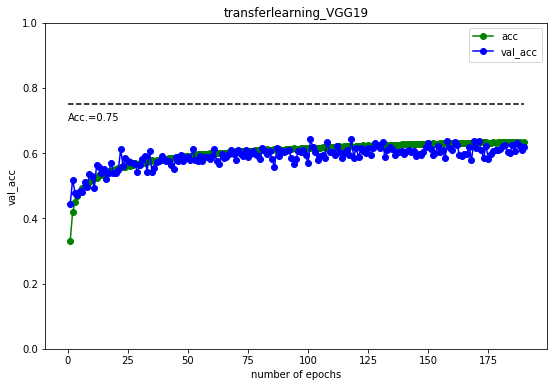

transferlearning_InceptionV3


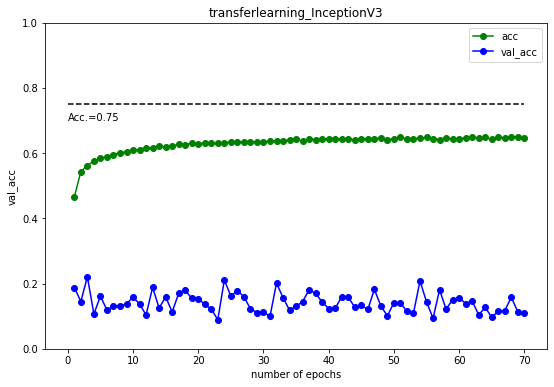

transferlearning_resnet50


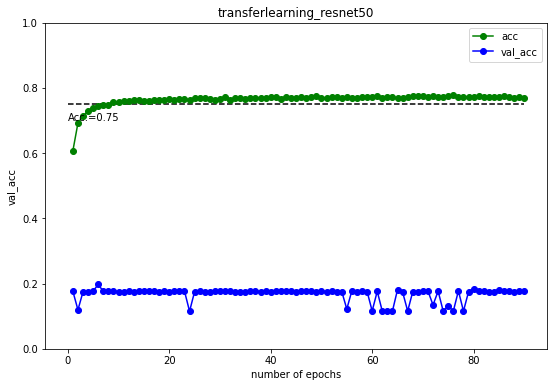

In [4]:
data = {}
targets = ["acc", "val_acc"]
line_style = ["-go", "-bo", "-ro", '-mo']
HISTORY_DIR_PATH = "./models_v2/history/"
history_subfolders = [(subfolder, join(HISTORY_DIR_PATH, subfolder)) for subfolder in listdir(HISTORY_DIR_PATH) if isdir(join(HISTORY_DIR_PATH, subfolder))]
for subdir, subdir_path in history_subfolders:
    split_sub = subdir.split('_')
    if split_sub[-1] == "history":
        histories = [(histo, join(subdir_path, histo)) for histo in listdir(subdir_path) if isfile(join(subdir_path, histo))]
        if not histories:
            continue
        epoch_list = []
        model_name = None
        for file_name, file_path in histories:
            pure_name = splitext(file_name)[0]
            split_pure_name = pure_name.split('_')
            
            if split_pure_name[0] != "000":
                try:
                    epoch_list.append((int(split_pure_name[-1]), file_path))
                    if not model_name:
                        model_name = "_".join(split_pure_name[:-1])
                except:
                    pass
        if "transferlearning" not in model_name:
            continue
        epoch_list.sort()
        
        
        all_stat = {}
        for target in targets:
            all_stat[target] = []
            
        for epoch_num, epoch_path in epoch_list:
            with open(epoch_path, 'rb') as handle:
                    histo = pickle.load(handle)
            for target in targets:
                all_stat[target] += histo[target]
        
        data[model_name] = {}
        print(model_name)
        plt.figure(1, (9,6))
        for idx, (k, v) in enumerate(all_stat.items()):
            plt.plot(list(range(1, epoch_list[-1][0]+1)), v, line_style[idx], label=k)
            data[model_name][k] = v
            
        plt.hlines(0.75, xmin=0, xmax=epoch_list[-1][0], linestyles='dashed')
        plt.text(x=0, y=0.70, s='Acc.=0.75')
        plt.ylim([0, 1])
        plt.legend(loc='best')
        plt.title(model_name)
        plt.xlabel("number of epochs")
        plt.ylabel(target)
        plt.show()
        

transferlearning_VGG16


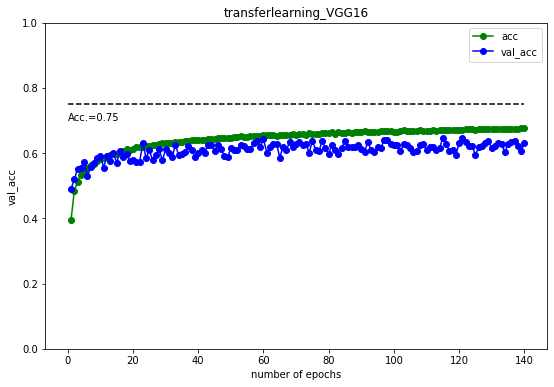

transferlearning_DenseNet121


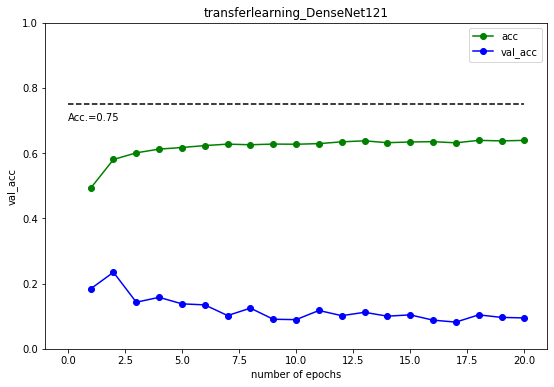

transferlearning_VGG19
0.62967855
0.6309375


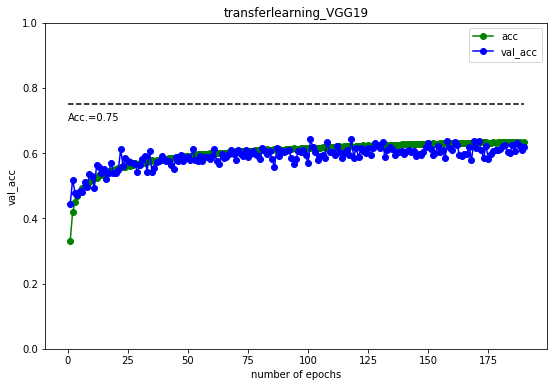

transferlearning_InceptionV3


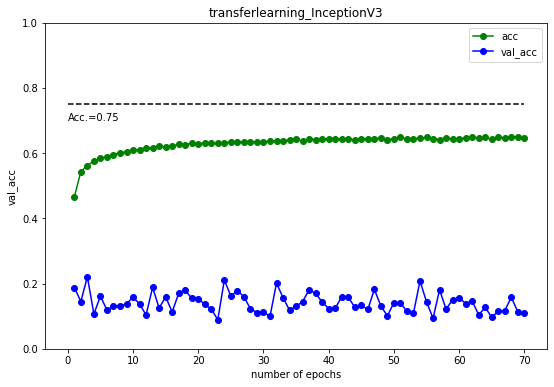

transferlearning_resnet50


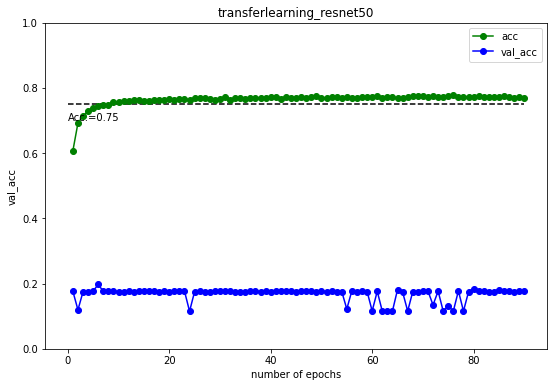

In [16]:
data = {}
targets = ["acc", "val_acc"]
line_style = ["-go", "-bo", "-ro", '-mo']
HISTORY_DIR_PATH = "./models_v2/history/"
history_subfolders = [(subfolder, join(HISTORY_DIR_PATH, subfolder)) for subfolder in listdir(HISTORY_DIR_PATH) if isdir(join(HISTORY_DIR_PATH, subfolder))]
for subdir, subdir_path in history_subfolders:
    split_sub = subdir.split('_')
    if split_sub[-1] == "history":
        histories = [(histo, join(subdir_path, histo)) for histo in listdir(subdir_path) if isfile(join(subdir_path, histo))]
        if not histories:
            continue
        epoch_list = []
        model_name = None
        for file_name, file_path in histories:
            pure_name = splitext(file_name)[0]
            split_pure_name = pure_name.split('_')
            
            if split_pure_name[0] != "000":
                try:
                    epoch_list.append((int(split_pure_name[-1]), file_path))
                    if not model_name:
                        model_name = "_".join(split_pure_name[:-1])
                except:
                    pass
        if "transferlearning" not in model_name:
            continue
        epoch_list.sort()
        
        
        all_stat = {}
        for target in targets:
            all_stat[target] = []
            
        for epoch_num, epoch_path in epoch_list:
            with open(epoch_path, 'rb') as handle:
                    histo = pickle.load(handle)
            for target in targets:
                all_stat[target] += histo[target]
        
        data[model_name] = {}
        print(model_name)
        plt.figure(1, (9,6))
        for idx, (k, v) in enumerate(all_stat.items()):
            plt.plot(list(range(1, epoch_list[-1][0]+1)), v, line_style[idx], label=k)
            try:
                print(v[149])
            except:
                pass
            data[model_name][k] = v
            
        plt.hlines(0.75, xmin=0, xmax=epoch_list[-1][0], linestyles='dashed')
        plt.text(x=0, y=0.70, s='Acc.=0.75')
        plt.ylim([0, 1])
        plt.legend(loc='best')
        plt.title(model_name)
        plt.xlabel("number of epochs")
        plt.ylabel(target)
        plt.show()
        

transferlearning_VGG16


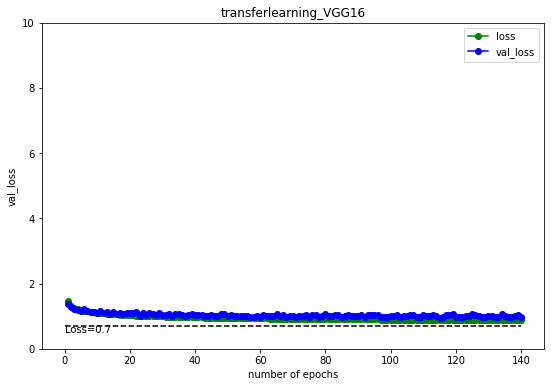

transferlearning_DenseNet121


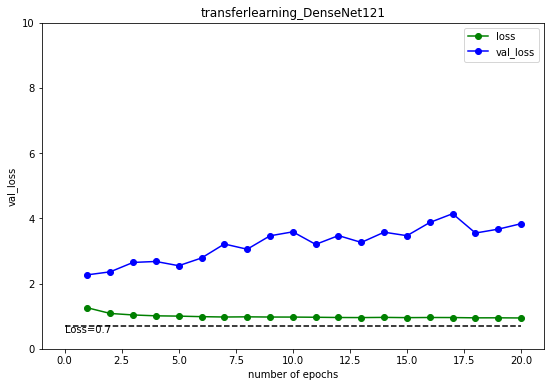

transferlearning_VGG19


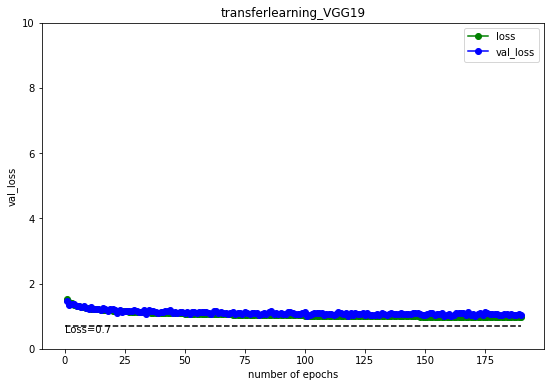

transferlearning_InceptionV3


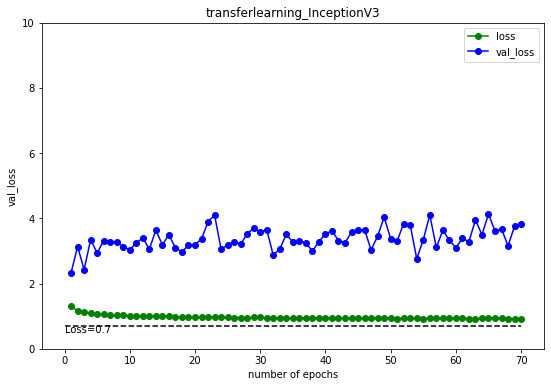

transferlearning_resnet50


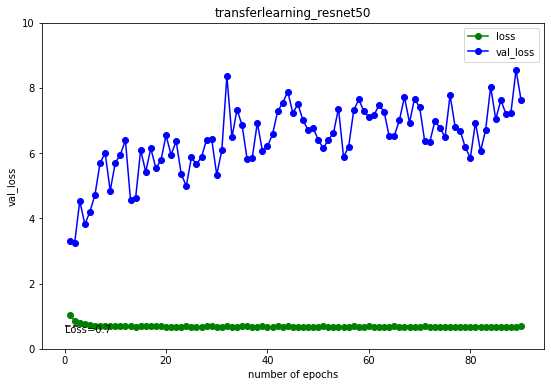

In [11]:
data = {}
targets = ["loss", "val_loss"]
line_style = ["-go", "-bo", "-ro", '-mo']
HISTORY_DIR_PATH = "./models_v2/history/"
history_subfolders = [(subfolder, join(HISTORY_DIR_PATH, subfolder)) for subfolder in listdir(HISTORY_DIR_PATH) if isdir(join(HISTORY_DIR_PATH, subfolder))]
for subdir, subdir_path in history_subfolders:
    split_sub = subdir.split('_')
    if split_sub[-1] == "history":
        histories = [(histo, join(subdir_path, histo)) for histo in listdir(subdir_path) if isfile(join(subdir_path, histo))]
        if not histories:
            continue
        epoch_list = []
        model_name = None
        for file_name, file_path in histories:
            pure_name = splitext(file_name)[0]
            split_pure_name = pure_name.split('_')
            
            if split_pure_name[0] != "000":
                try:
                    epoch_list.append((int(split_pure_name[-1]), file_path))
                    if not model_name:
                        model_name = "_".join(split_pure_name[:-1])
                except:
                    pass
        if "transferlearning" not in model_name:
            continue
        epoch_list.sort()
        
        
        all_stat = {}
        for target in targets:
            all_stat[target] = []
            
        for epoch_num, epoch_path in epoch_list:
            with open(epoch_path, 'rb') as handle:
                    histo = pickle.load(handle)
            for target in targets:
                all_stat[target] += histo[target]
        
        data[model_name] = {}
        print(model_name)
        plt.figure(1, (9,6))
        for idx, (k, v) in enumerate(all_stat.items()):
            plt.plot(list(range(1, epoch_list[-1][0]+1)), v, line_style[idx], label=k)
            data[model_name][k] = v
            
        plt.hlines(0.7, xmin=0, xmax=epoch_list[-1][0], linestyles='dashed')
        plt.text(x=0, y=0.5, s='Loss=0.7')
        plt.ylim([0, 10])
        plt.legend(loc='best')
        plt.title(model_name)
        plt.xlabel("number of epochs")
        plt.ylabel(target)
        plt.show()
        

transferlearning_VGG16


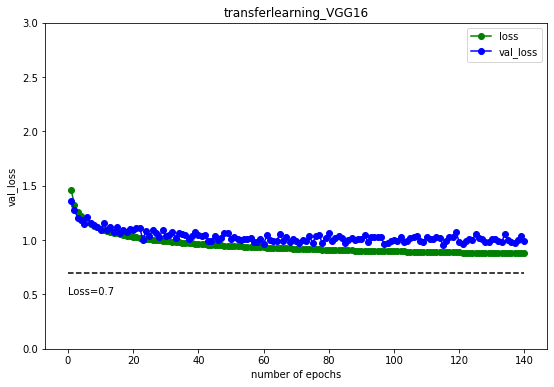

transferlearning_DenseNet121


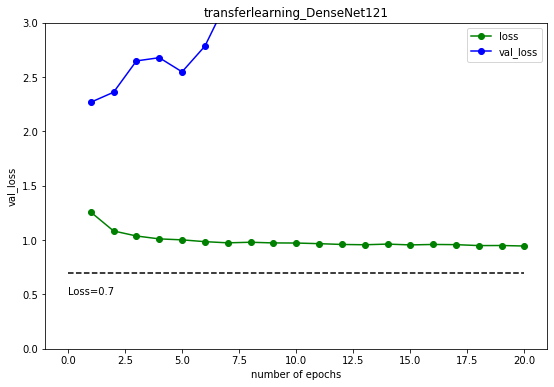

transferlearning_VGG19


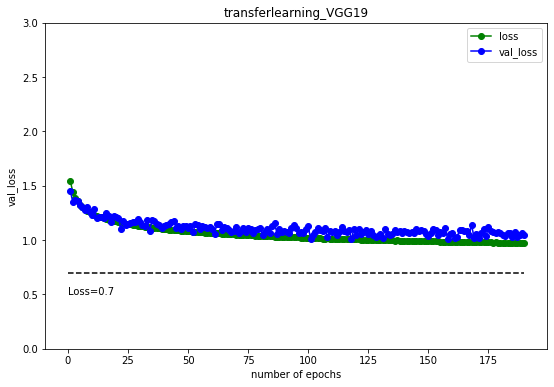

transferlearning_InceptionV3


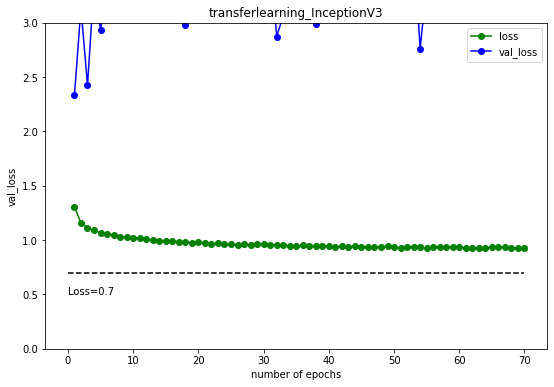

transferlearning_resnet50


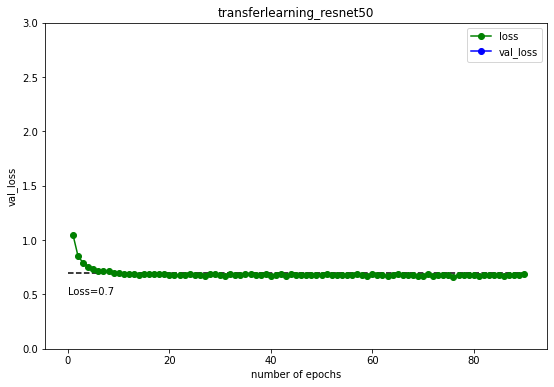

In [17]:
data = {}
targets = ["loss", "val_loss"]
line_style = ["-go", "-bo", "-ro", '-mo']
HISTORY_DIR_PATH = "./models_v2/history/"
history_subfolders = [(subfolder, join(HISTORY_DIR_PATH, subfolder)) for subfolder in listdir(HISTORY_DIR_PATH) if isdir(join(HISTORY_DIR_PATH, subfolder))]
for subdir, subdir_path in history_subfolders:
    split_sub = subdir.split('_')
    if split_sub[-1] == "history":
        histories = [(histo, join(subdir_path, histo)) for histo in listdir(subdir_path) if isfile(join(subdir_path, histo))]
        if not histories:
            continue
        epoch_list = []
        model_name = None
        for file_name, file_path in histories:
            pure_name = splitext(file_name)[0]
            split_pure_name = pure_name.split('_')
            
            if split_pure_name[0] != "000":
                try:
                    epoch_list.append((int(split_pure_name[-1]), file_path))
                    if not model_name:
                        model_name = "_".join(split_pure_name[:-1])
                except:
                    pass
        if "transferlearning" not in model_name:
            continue
        epoch_list.sort()
        
        
        all_stat = {}
        for target in targets:
            all_stat[target] = []
            
        for epoch_num, epoch_path in epoch_list:
            with open(epoch_path, 'rb') as handle:
                    histo = pickle.load(handle)
            for target in targets:
                all_stat[target] += histo[target]
        
        data[model_name] = {}
        print(model_name)
        plt.figure(1, (9,6))
        for idx, (k, v) in enumerate(all_stat.items()):
            plt.plot(list(range(1, epoch_list[-1][0]+1)), v, line_style[idx], label=k)
            data[model_name][k] = v
            
        plt.hlines(0.7, xmin=0, xmax=epoch_list[-1][0], linestyles='dashed')
        plt.text(x=0, y=0.5, s='Loss=0.7')
        plt.ylim([0, 3])
        plt.legend(loc='best')
        plt.title(model_name)
        plt.xlabel("number of epochs")
        plt.ylabel(target)
        plt.show()
        

In [18]:
from sklearn.metrics import classification_report
model = load_model("./models_v2/transferlearning_resnet50/000_transferlearning_resnet50_best_loss_10.h5")
train_per = model.evaluate(training_generator, verbose=1)
val_per = model.evaluate(validation_generator, verbose=1)
test_per = model.evaluate(test_generator, verbose=1)
print("Train accuracy:", train_per[1])
print("Validation accuracy:", val_per[1])
print("Test accuracy:", test_per[1])

4027/4027 [==============================] - 244s 60ms/step - loss: 5.1669 - acc: 0.1669
Train accuracy: 0.19989286
Validation accuracy: 0.17625
Test accuracy: 0.1668736


In [19]:
from sklearn.metrics import classification_report
model = load_model("./models_v2/transferlearning_InceptionV3/000_transferlearning_InceptionV3_best_loss_10.h5")
val_per = model.evaluate(validation_generator, verbose=1)
test_per = model.evaluate(test_generator, verbose=1)
print("Validation accuracy:", val_per[1])
print("Test accuracy:", test_per[1])

4027/4027 [==============================] - 157s 39ms/step - loss: 3.0261 - acc: 0.1619
Validation accuracy: 0.1584375
Test accuracy: 0.16190712


In [20]:
from sklearn.metrics import classification_report
model = load_model("./models_v2/transferlearning_DenseNet121/000_transferlearning_DenseNet121_best_loss_10.h5")
val_per = model.evaluate(validation_generator, verbose=1)
test_per = model.evaluate(test_generator, verbose=1)
print("Validation accuracy:", val_per[1])
print("Test accuracy:", test_per[1])

4027/4027 [==============================] - 263s 65ms/step - loss: 3.6084 - acc: 0.0827
Validation accuracy: 0.0896875
Test accuracy: 0.08269183


In [21]:
from sklearn.metrics import classification_report
model = load_model("./models_v2/transferlearning_VGG16/000_transferlearning_VGG16_best_loss_60.h5")
val_per = model.evaluate(validation_generator, verbose=1)
test_per = model.evaluate(test_generator, verbose=1)
print("Validation accuracy:", val_per[1])
print("Test accuracy:", test_per[1])

4027/4027 [==============================] - 68s 17ms/step - loss: 1.1449 - acc: 0.5580
Validation accuracy: 0.553125
Test accuracy: 0.55798364


In [22]:
from sklearn.metrics import classification_report
model = load_model("./models_v2/transferlearning_VGG19/000_transferlearning_VGG19_best_loss_150.h5")
val_per = model.evaluate(validation_generator, verbose=1)
test_per = model.evaluate(test_generator, verbose=1)
print("Validation accuracy:", val_per[1])
print("Test accuracy:", test_per[1])

4027/4027 [==============================] - 80s 20ms/step - loss: 1.0025 - acc: 0.6327
Validation accuracy: 0.6315625
Test accuracy: 0.63272905
